# Explore here

In [2]:
#Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold # <-- THIS is the missing line
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint



In [3]:
%matplotlib inline

In [4]:
#Cargar dataset solo con las columnas necesarias (se eliminaron principalmente las obvias)
df = pd.read_csv('../data/vehicles.csv', usecols=['region', 'price', 'year','manufacturer','model','condition','cylinders','fuel','odometer','transmission','drive','size','type','paint_color','description','state']) #cargar solo las columnas necesarias

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        426880 non-null  object 
 1   price         426880 non-null  int64  
 2   year          425675 non-null  float64
 3   manufacturer  409234 non-null  object 
 4   model         421603 non-null  object 
 5   condition     252776 non-null  object 
 6   cylinders     249202 non-null  object 
 7   fuel          423867 non-null  object 
 8   odometer      422480 non-null  float64
 9   transmission  424324 non-null  object 
 10  drive         296313 non-null  object 
 11  size          120519 non-null  object 
 12  type          334022 non-null  object 
 13  paint_color   296677 non-null  object 
 14  description   426810 non-null  object 
 15  state         426880 non-null  object 
dtypes: float64(2), int64(1), object(13)
memory usage: 52.1+ MB


In [6]:
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,size,type,paint_color,description,state
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [7]:
print(f"Numero de datos nulos: {(df.isnull().sum().sum())}")
print(f"Numero de datos duplicados: {(df.duplicated().sum())}")
print(f"Numero de filas con precios negativos o cero: {(df[df['price'] <= 0].shape[0])}")
print(f"Numero de filas con kilometraje negativo o cero: {(df[df['odometer'] <= 0].shape[0])}")
print(f'Numero de filas con columnas description, condition, type, region, model: {(df[df[['description', 'condition', 'type', 'region', 'model']].isnull().any(axis=1)].shape[0])}')


Numero de datos nulos: 1045938
Numero de datos duplicados: 31697
Numero de filas con precios negativos o cero: 32895
Numero de filas con kilometraje negativo o cero: 1965
Numero de filas con columnas description, condition, type, region, model: 208366


Procedemos a eliminar datos nulos, duplicados, precios negativos o cero, kilometraje en negativo o cero, y columnas adicionales que no se van a utilizar. 

In [8]:
df.drop(columns=['description','condition','type','region','model'],inplace=True) #se decide eliminar otras variables. Model por ejemplo por dificultad en exploracion de datos. 
df.dropna(inplace=True) #eliminamos filas con valores nulos
df.drop_duplicates(inplace=True) #eliminamos filas duplicadas
df = df[df['price'] > 0] #eliminamos filas con precios negativos o cero
df = df[df['odometer'] > 0] #eliminamos filas con odometro negativo o cero


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73074 entries, 31 to 426833
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         73074 non-null  int64  
 1   year          73074 non-null  float64
 2   manufacturer  73074 non-null  object 
 3   cylinders     73074 non-null  object 
 4   fuel          73074 non-null  object 
 5   odometer      73074 non-null  float64
 6   transmission  73074 non-null  object 
 7   drive         73074 non-null  object 
 8   size          73074 non-null  object 
 9   paint_color   73074 non-null  object 
 10  state         73074 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 6.7+ MB


In [10]:
#cambiar floats a int
pd.set_option('display.max_columns', None)
df['year'].fillna(0, inplace=True)
df['year'] = df['year'].astype(int)
df['odometer'] = df['odometer'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73074 entries, 31 to 426833
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         73074 non-null  int64 
 1   year          73074 non-null  int64 
 2   manufacturer  73074 non-null  object
 3   cylinders     73074 non-null  object
 4   fuel          73074 non-null  object
 5   odometer      73074 non-null  int64 
 6   transmission  73074 non-null  object
 7   drive         73074 non-null  object
 8   size          73074 non-null  object
 9   paint_color   73074 non-null  object
 10  state         73074 non-null  object
dtypes: int64(3), object(8)
memory usage: 6.7+ MB


C:\Users\Juan\AppData\Local\Temp\ipykernel_4532\1492360359.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['year'].fillna(0, inplace=True)


In [11]:
#Rango de precios
min_price = df['price'].min()
max_price = df['price'].max()
print(f"Price Range: ${min_price} to ${max_price}\n")
#Rango de Años
min_year = df['year'].min()
max_year = df['year'].max()
print(f"Year Range: {min_year} to {max_year}\n")
#Tipos de Size
SizeUnique = df['size'].unique()
print(f'Unique Sizes: {SizeUnique}')
print("\n")
#Tipos de manufacturer
ManufacturerUnique = df['manufacturer'].unique()
print(f'Unique Manufacturers: {ManufacturerUnique}')
print("\n")
#Tipos de Cylinders
CylindersUnique = df['cylinders'].unique()
print(f'Unique Cylinders: {CylindersUnique}')
print("\n")
#Tipos de Fuel
FuelUnique = df['fuel'].unique()
print(f'Unique Fuel Types: {FuelUnique}')
print("\n")
#Rango de Odometer
min_odometer = df['odometer'].min()
max_odometer = df['odometer'].max()
print(f"Odometer Range: {min_odometer} to {max_odometer}\n")
print("\n")
#Tipos de Transmission
TransmissionUnique = df['transmission'].unique()
print(f'Unique Transmissions: {TransmissionUnique}')  
print("\n")
#Tipos de Drive
DriveUnique = df['drive'].unique()
print(f'Unique Drives: {DriveUnique}')
print("\n")
#Tipos de Paint Color
PaintColorUnique = df['paint_color'].unique()  
print(f'Unique Paint Colors: {PaintColorUnique}')
print("\n")
#Tipos de State
StateUnique = df['state'].unique()
print(f'Unique States: {StateUnique}')  


Price Range: $1 to $3736928711

Year Range: 1900 to 2022

Unique Sizes: ['full-size' 'mid-size' 'compact' 'sub-compact']


Unique Manufacturers: ['ford' 'honda' 'dodge' 'chrysler' 'toyota' 'jeep' 'lexus' 'chevrolet'
 'bmw' 'gmc' 'mercedes-benz' 'mazda' 'rover' 'ram' 'nissan' 'ferrari'
 'audi' 'mitsubishi' 'infiniti' 'volkswagen' 'kia' 'pontiac' 'hyundai'
 'fiat' 'acura' 'cadillac' 'lincoln' 'jaguar' 'saturn' 'volvo'
 'alfa-romeo' 'buick' 'subaru' 'mini' 'mercury' 'porsche'
 'harley-davidson' 'tesla' 'datsun' 'land rover' 'aston-martin']


Unique Cylinders: ['6 cylinders' '8 cylinders' '4 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']


Unique Fuel Types: ['gas' 'diesel' 'hybrid' 'electric' 'other']


Odometer Range: 1 to 10000000



Unique Transmissions: ['automatic' 'manual' 'other']


Unique Drives: ['rwd' '4wd' 'fwd']


Unique Paint Colors: ['black' 'blue' 'silver' 'white' 'grey' 'yellow' 'red' 'green' 'brown'
 'purple' 'custom' 'orange']


Unique Sta

In [12]:
#Tipos de Paint Color
PaintColorUnique = df['paint_color'].unique()  
print(f'Unique Paint Colors: {PaintColorUnique}')

Unique Paint Colors: ['black' 'blue' 'silver' 'white' 'grey' 'yellow' 'red' 'green' 'brown'
 'purple' 'custom' 'orange']


Procedemos a Analizar la Variable PRECIO: 

In [13]:
df['price'].describe().apply(lambda x: format(x, 'f'))


count         73074.000000
mean         137310.776364
std        19993993.855796
min               1.000000
25%            5695.000000
50%           10000.000000
75%           18995.000000
max      3736928711.000000
Name: price, dtype: object

El hecho de que haya una diferencia significante entre la media ($137,310) y la mediana nos indica que la distribucion esta sesgada a la derecha. Esto causado por outliers extremos. 
El precio minimo de $1 tambien es sospechoso. 
Los valores mas tipicos en precio en este dataset estan entre $5,695 y $18,995 indicado por los cuartiles.

In [14]:
df.sort_values(by='price', ascending=False).head(50)


,price,year,manufacturer,cylinders,fuel,odometer,transmission,drive,size,paint_color,state
356716,3736928711,1999,toyota,6 cylinders,gas,211000,automatic,4wd,mid-size,green,tn
318592,3736928711,2007,toyota,8 cylinders,gas,164000,automatic,4wd,full-size,silver,or
29386,1111111111,1999,ford,8 cylinders,diesel,149000,automatic,rwd,full-size,white,ca
230753,135008900,2008,nissan,8 cylinders,gas,110500,automatic,4wd,full-size,grey,nc
307488,123456789,1996,gmc,8 cylinders,gas,320000,automatic,4wd,full-size,black,ok
137807,123456789,1999,buick,6 cylinders,gas,96000,automatic,fwd,full-size,white,id
136516,17000000,2007,ram,8 cylinders,diesel,170000,automatic,4wd,full-size,black,id
286323,12345678,2019,chevrolet,8 cylinders,gas,100000,automatic,4wd,full-size,black,oh
68935,2000000,2002,saturn,4 cylinders,gas,164290,automatic,fwd,mid-size,green,ca
155421,1234567,2006,jeep,6 cylinders,gas,123456,automatic,4wd,mid-size,custom,in


Las primeras 11 publicaciones parecen ser un error debido a lo poco probable de que ese sea el valor del precio real por lo que se proceden a eliminar todos las publicaciones con precios por encima de $230,000

In [15]:
df.sort_values(by='price', ascending=True).head(1000)


,price,year,manufacturer,cylinders,fuel,odometer,transmission,drive,size,paint_color,state
92659,1,2017,ford,10 cylinders,gas,38374,automatic,rwd,full-size,black,fl
93125,1,2016,toyota,10 cylinders,gas,68339,automatic,rwd,full-size,blue,fl
145404,1,1967,chevrolet,8 cylinders,gas,1,other,rwd,mid-size,blue,il
145510,1,2019,ram,8 cylinders,gas,18863,automatic,4wd,full-size,grey,il
92741,1,2016,infiniti,6 cylinders,gas,59762,other,4wd,compact,white,fl
...,...,...,...,...,...,...,...,...,...,...,...
319761,800,2004,volvo,5 cylinders,gas,176000,automatic,fwd,full-size,white,or
191749,800,2001,ford,4 cylinders,gas,178734,manual,fwd,compact,grey,ma
117199,800,2001,honda,4 cylinders,gas,216000,automatic,fwd,compact,white,fl
272706,800,2001,jeep,6 cylinders,gas,179000,automatic,4wd,mid-size,silver,ny


Debido a valores muy bajos que lo mas probable es que sean un error, tambien se elimina toda publicacion que tenga un precio por debajo de $1000. 

In [16]:
price_filter = (df['price'] > 1000) & (df['price'] < 230000)
#top_10_manufacturers = df_cleaned['manufacturer'].value_counts().head(10).index.tolist()
#manufacturer_filter = df_cleaned['manufacturer'].isin(top_10_manufacturers)

df_filtrado = df[price_filter]
df_filtrado.describe()





,price,year,odometer
count,71506.000000,71506.000000,7.150600e+04
mean,14439.125612,2008.324280,1.199394e+05
std,12394.787236,10.660333,2.047985e+05
min,1050.000000,1900.000000,1.000000e+00
25%,5977.000000,2005.000000,6.800000e+04
50%,10500.000000,2011.000000,1.103390e+05
75%,19346.750000,2015.000000,1.540000e+05
max,229500.000000,2022.000000,1.000000e+07


In [17]:
df_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71506 entries, 31 to 426833
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         71506 non-null  int64 
 1   year          71506 non-null  int64 
 2   manufacturer  71506 non-null  object
 3   cylinders     71506 non-null  object
 4   fuel          71506 non-null  object
 5   odometer      71506 non-null  int64 
 6   transmission  71506 non-null  object
 7   drive         71506 non-null  object
 8   size          71506 non-null  object
 9   paint_color   71506 non-null  object
 10  state         71506 non-null  object
dtypes: int64(3), object(8)
memory usage: 6.5+ MB


Aun despues de la limpieza de datos con respecto a precio,suficientes datos para seguir trabajando con el dataset. 
Estas son las siguientes conclusiones:
1. La desviacion estandar ($12,395) es mas baja que la media ($14,439) lo cual es tipico para datos con respecto a precio. 
2. La media ($14,439) y la mediana ($10,500) estan mucho mas cerca entre una y otra, a diferencia de la anterior que tenia una diferencia de mas de $127,000 entre una y otra. Aun asi cuando la media es mas alta que la mediana, indicando sesgo hacia la derecha, sin embargo no tan severo como antes.
NOTA: LUEGO DE PROBAR EL MODELO PODEMOS INTENTAR UN LOG TRANSFORMATION A VER SI OBTENEMOS MEJORES RESULTADOS. 


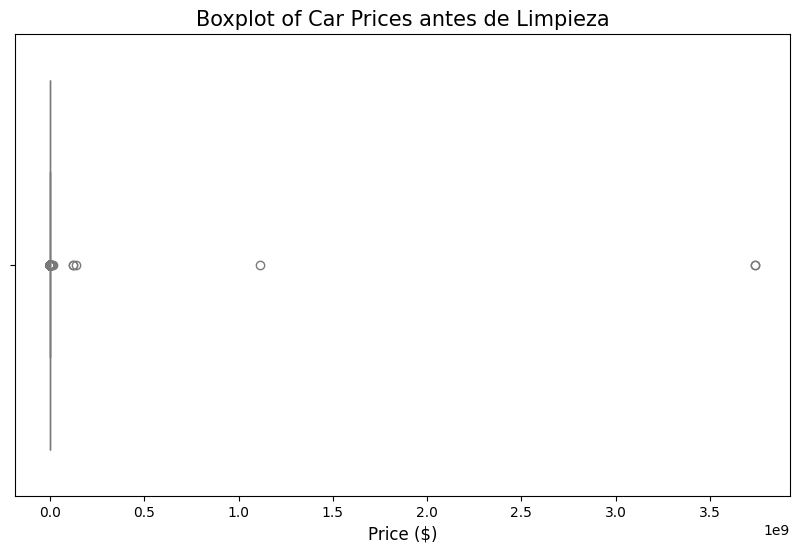

In [18]:
# Create a figure and an axes object
plt.figure(figsize=(10, 6))
# Generate the boxplot
# We use a horizontal orientation for better readability of the price scale
sns.boxplot(x=df['price'], color='lightblue')
# Add titles and labels for clarity
plt.title('Boxplot of Car Prices antes de Limpieza', fontsize=15)
plt.xlabel('Price ($)', fontsize=12)
# Show the plot
plt.show()

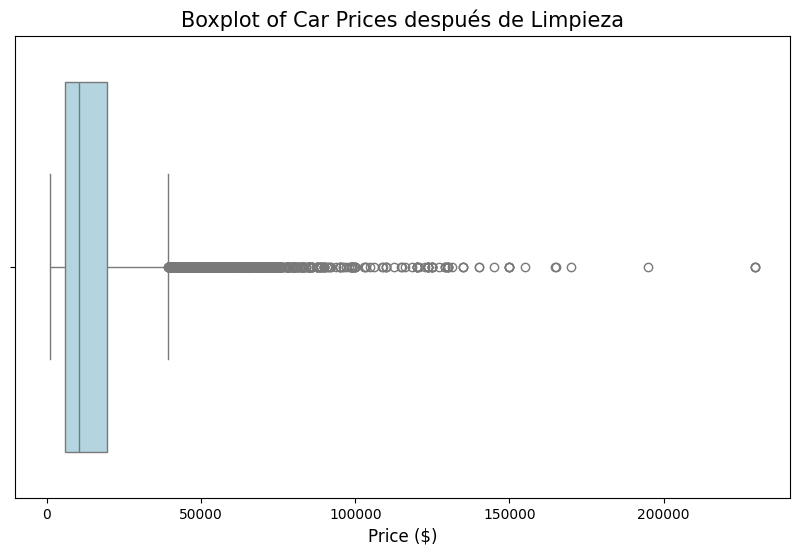

In [19]:
# Create a figure and an axes object
plt.figure(figsize=(10, 6))
# Generate the boxplot
# We use a horizontal orientation for better readability of the price scale
sns.boxplot(x=df_filtrado['price'], color='lightblue')
# Add titles and labels for clarity
plt.title('Boxplot of Car Prices después de Limpieza', fontsize=15)
plt.xlabel('Price ($)', fontsize=12)
# Show the plot
plt.show()

In [20]:
df_filtrado2 = df_filtrado[df_filtrado['year'] >= 1980].copy() #eliminamos carros muy viejos, menos de 1980
# Paso 2: Creación del feature 'age'
ANO_ACTUAL = 2025
df_filtrado2['age'] = ANO_ACTUAL - df_filtrado2['year']
df_filtrado2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69304 entries, 31 to 426833
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         69304 non-null  int64 
 1   year          69304 non-null  int64 
 2   manufacturer  69304 non-null  object
 3   cylinders     69304 non-null  object
 4   fuel          69304 non-null  object
 5   odometer      69304 non-null  int64 
 6   transmission  69304 non-null  object
 7   drive         69304 non-null  object
 8   size          69304 non-null  object
 9   paint_color   69304 non-null  object
 10  state         69304 non-null  object
 11  age           69304 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 6.9+ MB


Se crea la columna EDAD para poder visualizar mejor esta variable representativa de cuan antiguo es el carro siendo analizado. Esta columna sustituira la columna YEAR

In [21]:
df_filtrado2.head()

,price,year,manufacturer,cylinders,fuel,odometer,transmission,drive,size,paint_color,state,age
31,15000,2013,ford,6 cylinders,gas,128000,automatic,rwd,full-size,black,al,12
55,19900,2004,ford,8 cylinders,diesel,88000,automatic,4wd,full-size,blue,al,21
59,14000,2012,honda,6 cylinders,gas,95000,automatic,fwd,full-size,silver,al,13
65,22500,2001,ford,8 cylinders,diesel,144700,manual,rwd,full-size,white,al,24
73,15000,2017,dodge,8 cylinders,gas,90000,automatic,rwd,mid-size,grey,al,8


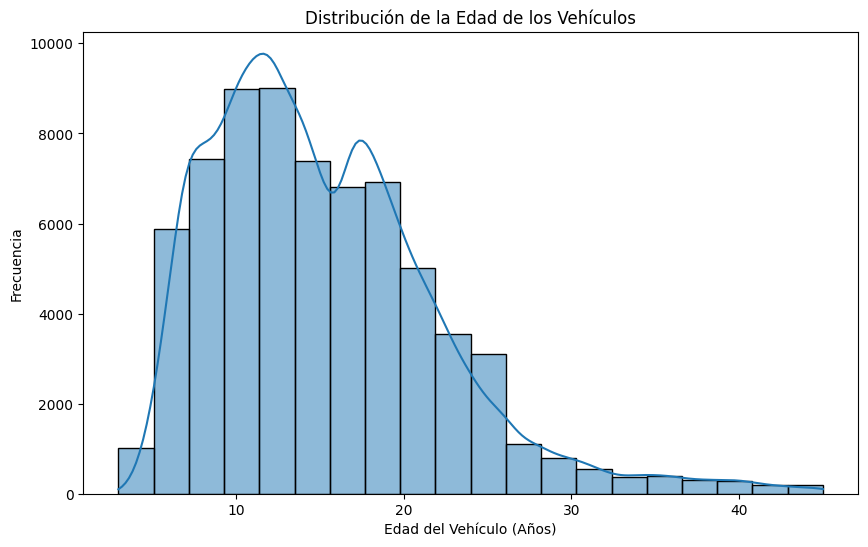

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtrado2['age'], kde=True, bins=20)
plt.title('Distribución de la Edad de los Vehículos')
plt.xlabel('Edad del Vehículo (Años)')
plt.ylabel('Frecuencia')
plt.show()

In [23]:
def visualizar_edad_vs_precio(df_filtrado2):
  """
  Genera un diagrama de dispersión para visualizar la relación entre 
  la edad del vehículo y su precio, sin usar escala logarítmica.

  Args:
      df (pd.DataFrame): El DataFrame que contiene las columnas 'age' y 'price'.
  """
  plt.figure(figsize=(10, 6))
  
  # Gráfico de dispersión con 'age' en el eje X y 'price' en el eje Y (escala normal)
  sns.scatterplot(x='age', y='price', data=df_filtrado2) 
  
  plt.title('Precio vs. Edad del Vehículo (Datos Limpios)')
  plt.xlabel('Edad del Vehículo (Años)')
  plt.ylabel('Precio ($)')
  plt.grid(True)
  plt.show()

# Ejemplo de uso (asumiendo que tu DataFrame limpio se llama 'df_limpio'):
# visualizar_edad_vs_precio(df_limpio)

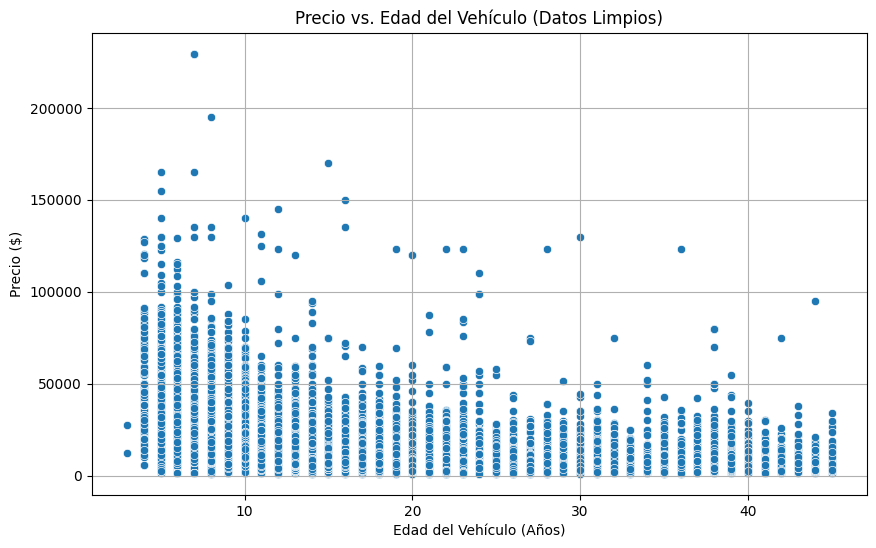

In [24]:
visualizar_edad_vs_precio(df_filtrado2)


Podemos notar una tendencia negativa que los precios van disminuyendo en tendencia conforme el auto se va convirtiendo mas viejo. Con excepciones que pueden ser a causa de autos pequenos, de coleccion, etc...

In [25]:
odometer_filter = (df_filtrado2['odometer'] > 50) & (df_filtrado2['odometer'] < 500000)
#top_10_manufacturers = df_cleaned['manufacturer'].value_counts().head(10).index.tolist()
#manufacturer_filter = df_cleaned['manufacturer'].isin(top_10_manufacturers)

df_filtrado3 = df_filtrado2[odometer_filter]
df_filtrado3.describe()


,price,year,odometer,age
count,68974.00000,68974.000000,68974.000000,68974.000000
mean,14311.56314,2009.746020,115647.234755,15.253980
std,12188.25235,6.822428,62473.068560,6.822428
min,1050.00000,1980.000000,52.000000,4.000000
25%,5950.00000,2006.000000,70000.000000,10.000000
50%,10500.00000,2011.000000,112500.000000,14.000000
75%,18999.00000,2015.000000,155000.000000,19.000000
max,229500.00000,2021.000000,499232.000000,45.000000


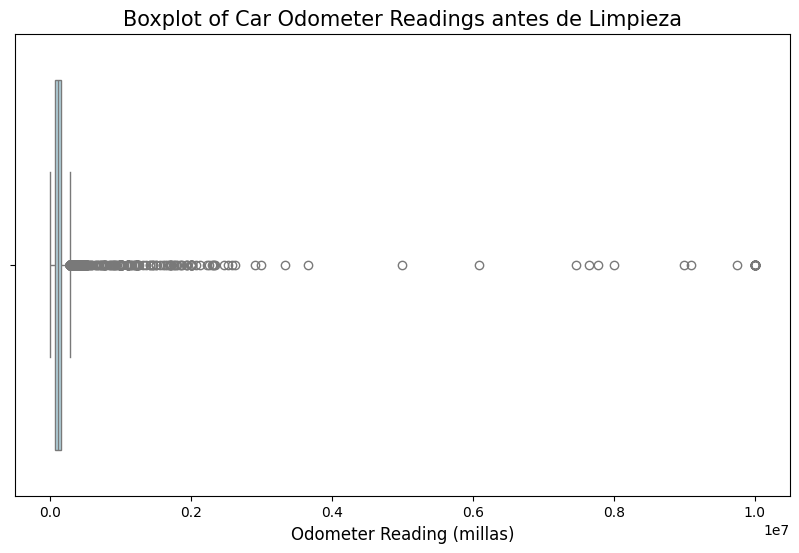

In [26]:
# Create a figure and an axes object
plt.figure(figsize=(10, 6))
# Generate the boxplot
# We use a horizontal orientation for better readability of the odometer scale
sns.boxplot(x=df['odometer'], color='lightblue')
# Add titles and labels for clarity
plt.title('Boxplot of Car Odometer Readings antes de Limpieza', fontsize=15)
plt.xlabel('Odometer Reading (millas)', fontsize=12)
# Show the plot
plt.show()

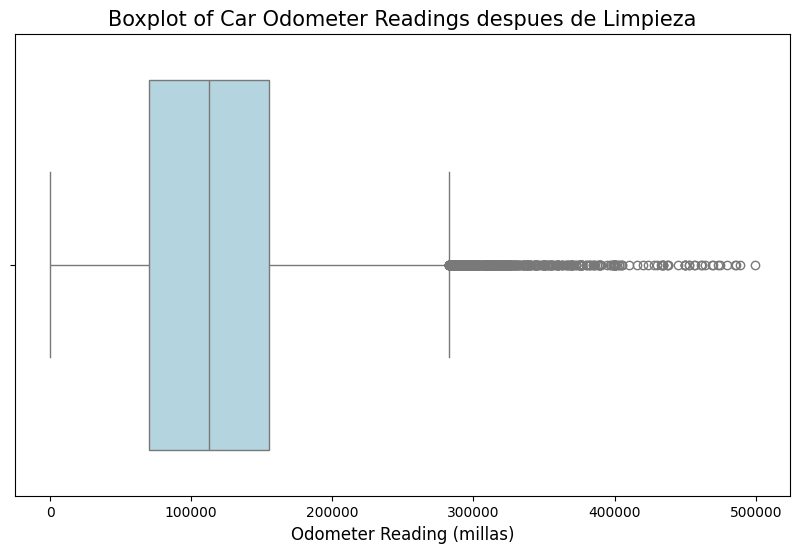

In [27]:
# Create a figure and an axes object
plt.figure(figsize=(10, 6))
# Generate the boxplot
# We use a horizontal orientation for better readability of the odometer scale
sns.boxplot(x=df_filtrado3['odometer'], color='lightblue')
# Add titles and labels for clarity
plt.title('Boxplot of Car Odometer Readings despues de Limpieza', fontsize=15)
plt.xlabel('Odometer Reading (millas)', fontsize=12)
# Show the plot
plt.show()

Ahora procedemos a crear un DF final con los valores numericos que nos interesan: 

In [28]:
df_limpio_temp = df[
    (df['price'] >= 1000) & 
    (df['price'] <= 230000) & 
    (df['year'] >= 1980) 
].copy()

In [29]:
df_final = df_limpio_temp[
    (df_limpio_temp['odometer'] <= 500000) & 
    (df_limpio_temp['odometer'] >= 50)
].copy()


In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69278 entries, 31 to 426833
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   price         69278 non-null  int64 
 1   year          69278 non-null  int64 
 2   manufacturer  69278 non-null  object
 3   cylinders     69278 non-null  object
 4   fuel          69278 non-null  object
 5   odometer      69278 non-null  int64 
 6   transmission  69278 non-null  object
 7   drive         69278 non-null  object
 8   size          69278 non-null  object
 9   paint_color   69278 non-null  object
 10  state         69278 non-null  object
dtypes: int64(3), object(8)
memory usage: 6.3+ MB


In [31]:
df_final.describe()


,price,year,odometer
count,69278.000000,69278.000000,69278.000000
mean,14257.381059,2009.720748,115869.653483
std,12204.841975,6.833767,62671.354904
min,1000.000000,1980.000000,50.000000
25%,5900.000000,2006.000000,70200.000000
50%,10491.000000,2011.000000,112761.500000
75%,18995.000000,2015.000000,155312.750000
max,229500.000000,2021.000000,500000.000000


In [32]:
ANO_ACTUAL = 2025 # O el año de referencia de tu dataset
df_final['age'] = ANO_ACTUAL - df_final['year']


In [33]:
df_final.drop('year', axis=1, inplace=True)


In [34]:
df_final.head()

,price,manufacturer,cylinders,fuel,odometer,transmission,drive,size,paint_color,state,age
31,15000,ford,6 cylinders,gas,128000,automatic,rwd,full-size,black,al,12
55,19900,ford,8 cylinders,diesel,88000,automatic,4wd,full-size,blue,al,21
59,14000,honda,6 cylinders,gas,95000,automatic,fwd,full-size,silver,al,13
65,22500,ford,8 cylinders,diesel,144700,manual,rwd,full-size,white,al,24
73,15000,dodge,8 cylinders,gas,90000,automatic,rwd,mid-size,grey,al,8


In [35]:
df_copy = df_final.copy()


Ingeneria de Caracteristicas para Variables Categoricas: 

Variables Categoricas

In [36]:
def contar_top_manufacturers(df_final, n=30):
  """
  Cuenta el número de listings por fabricante y muestra el top N.

  Args:
      df (pd.DataFrame): El DataFrame que contiene la columna 'manufacturer'.
      n (int): El número de fabricantes principales a mostrar (por defecto 10).

  Returns:
      pd.Series: Una Serie con el recuento de los top N fabricantes.
  """
  if 'manufacturer' not in df.columns:
    print("Error: El DataFrame no contiene la columna 'manufacturer'.")
    return None
    
  # Contar los valores únicos en la columna 'manufacturer'
  # y ordenarlos en orden descendente.
  conteo_manufacturers = df_final['manufacturer'].value_counts()
  
  # Seleccionar y devolver los N principales
  top_n_manufacturers = conteo_manufacturers.head(n)
  
  print(f"Top {n} Fabricantes con más publicaciones:")
  return top_n_manufacturers


In [37]:
print(contar_top_manufacturers(df_final, n=30))

Top 30 Fabricantes con más publicaciones:
manufacturer
ford             12850
chevrolet         9506
toyota            6544
honda             4702
nissan            3592
jeep              2888
gmc               2623
ram               2509
bmw               2323
dodge             2043
mercedes-benz     1891
subaru            1781
hyundai           1649
volkswagen        1534
lexus             1259
chrysler          1151
kia               1149
cadillac           997
mazda              948
audi               934
buick              871
acura              707
lincoln            577
infiniti           576
volvo              545
pontiac            528
mitsubishi         514
mini               449
rover              361
mercury            315
Name: count, dtype: int64


Los voy a dejar todos para ver si eliminando valores, logro obtener un mejor resultado luego.

In [38]:
# 1. Definir las columnas de baja cardinalidad
columnas_one_hot = ['cylinders', 'fuel', 'transmission', 'drive', 'size']
# 2. Aplicar One-Hot Encoding
for feature in columnas_one_hot:
    dummies = pd.get_dummies(df_final[feature], prefix=feature, drop_first=True)
    df_final = pd.concat([df_final, dummies], axis=1)
    df_final.drop(feature, axis=1, inplace=True)

df_final.head()

,price,manufacturer,odometer,paint_color,state,age,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact
31,15000,ford,128000,black,al,12,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False
55,19900,ford,88000,blue,al,21,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
59,14000,honda,95000,silver,al,13,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False
65,22500,ford,144700,white,al,24,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False
73,15000,dodge,90000,grey,al,8,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False


In [39]:
def target_encode_kfold(df_final, columna, target='price', n_splits=5):
    """
    Aplica Target Encoding (Out-of-Fold Mean Encoding) a una columna categórica.
    
    Args:
        df_final (pd.DataFrame): DataFrame de entrada.
        columna (str): Nombre de la columna categórica a codificar.
        target (str): Nombre de la variable objetivo ('price').
        n_splits (int): Número de pliegues (folds) para la Validación Cruzada.

    Returns:
        pd.Series: Serie con la nueva característica codificada.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    columna_codificada = pd.Series(np.nan, index=df_final.index)

    # 1. Iterar sobre los pliegues de Validación Cruzada
    for tr_idx, val_idx in kf.split(df_final):
        # Calcular la media (target) SÓLO con los datos de entrenamiento (tr_idx)
        mean_target = df_final.iloc[tr_idx].groupby(columna)[target].mean()

        # Asignar esa media a los datos de validación (val_idx)
        columna_codificada.iloc[val_idx] = df_final.iloc[val_idx][columna].map(mean_target)

    # 2. Manejar categorías que solo aparecen en la muestra de validación
    # Asignar la media global del target a cualquier valor restante (NaN)
    global_mean = df_final[target].mean()
    columna_codificada.fillna(global_mean, inplace=True)
    
    return columna_codificada

# -----------------------------------------------------------
# 2. Aplicación a las Columnas 'manufacturer', 'paint_color', 'state'
# -----------------------------------------------------------
def aplicar_target_encoding_completo(df_final):
    """
    Aplica Target Encoding con KFold a las columnas especificadas y elimina las originales.
    
    Args:
        df_final (pd.DataFrame): DataFrame que ya pasó por One-Hot Encoding.

    Returns:
        pd.DataFrame: DataFrame con las nuevas columnas codificadas.
    """
    columnas_target_encode = ['manufacturer', 'paint_color', 'state']

    for col in columnas_target_encode:
        nuevo_nombre = f'{col}_encoded'
        
        # Aplicar la función de Target Encoding con KFold
        df_final[nuevo_nombre] = target_encode_kfold(df_final, col)
        
        # Eliminar la columna categórica original
        df_final.drop(col, axis=1, inplace=True)
        
        print(f"Columna '{col}' codificada como '{nuevo_nombre}' y eliminada.")
        
    return df_final

# --- Ejemplo de uso ---
# Asumiendo que df_final es tu DataFrame después del One-Hot Encoding
#df_final = aplicar_target_encoding_completo(df_final)

In [40]:
df_final = aplicar_target_encoding_completo(df_final)

Columna 'manufacturer' codificada como 'manufacturer_encoded' y eliminada.
Columna 'paint_color' codificada como 'paint_color_encoded' y eliminada.
Columna 'state' codificada como 'state_encoded' y eliminada.


In [41]:
df_final.head()

,price,odometer,age,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders,cylinders_other,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,transmission_other,drive_fwd,drive_rwd,size_full-size,size_mid-size,size_sub-compact,manufacturer_encoded,paint_color_encoded,state_encoded
31,15000,128000,12,False,False,False,False,True,False,False,False,True,False,False,False,False,False,True,True,False,False,16714.947836,15585.572985,17635.933735
55,19900,88000,21,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,16714.947836,11941.678374,17635.933735
59,14000,95000,13,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,10063.927865,11910.346444,17391.479881
65,22500,144700,24,False,False,False,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,16714.947836,17198.323753,17635.933735
73,15000,90000,8,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,True,False,11877.436353,13918.155058,17635.933735


In [42]:
# 1. Separar la variable objetivo (y) de las características (X)
X = df_final.drop('price', axis=1)
y = df_final['price']

# 2. Dividir en conjuntos de entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamaño del conjunto de entrenamiento: {len(X_train)}")
print(f"Tamaño del conjunto de prueba: {len(X_test)}")

Tamaño del conjunto de entrenamiento: 55422
Tamaño del conjunto de prueba: 13856


In [43]:
#Random Forest Regressor

# 1. Crear y entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=15)
rf_model.fit(X_train, y_train)

# 2. Realizar predicciones
rf_predictions = rf_model.predict(X_test)

# 3. Evaluar el rendimiento
mae_rf = mean_absolute_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))

print("\n--- Resultados de Random Forest ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${rmse_rf:,.2f}")


--- Resultados de Random Forest ---
Raíz del Error Cuadrático Medio (RMSE): $5,292.18


In [44]:
# Crear y entrenar el modelo de XGBoost
xgb_regressor = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_regressor.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_xgb = xgb_regressor.predict(X_test)

# Calcular y mostrar el RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print("\n--- Resultados de XGBoost ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${rmse_xgb:,.2f}")



--- Resultados de XGBoost ---
Raíz del Error Cuadrático Medio (RMSE): $5,273.55


In [45]:
print("\n--- Resultados de Random Forest ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${rmse_rf:,.2f}")
print("\n--- Resultados de XGBoost ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${rmse_xgb:,.2f}")


--- Resultados de Random Forest ---
Raíz del Error Cuadrático Medio (RMSE): $5,292.18

--- Resultados de XGBoost ---
Raíz del Error Cuadrático Medio (RMSE): $5,273.55


In [46]:
# 1. Definir el espacio de búsqueda de hiperparámetros
# Usaremos distribuciones para que RandomizedSearchCV escoja valores inteligentemente.
param_dist = {
    # Número de árboles: un rango amplio para empezar
    'n_estimators': randint(300, 1000), 
    
    # Tasa de aprendizaje: Valores más bajos suelen ser mejores, pero más lentos
    'learning_rate': uniform(0.01, 0.1), # Rango de 0.01 a 0.11
    
    # Profundidad máxima del árbol: entre 5 y 10 suele ser un buen balance
    'max_depth': randint(5, 10), 
    
    # Fracción de columnas a muestrear por árbol
    'colsample_bytree': uniform(0.5, 0.5), # Rango de 0.5 a 1.0
    
    # Fracción de filas a muestrear por árbol
    'subsample': uniform(0.6, 0.4), # Rango de 0.6 a 1.0
    
    # Parámetros para evitar el sobreajuste
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 0.5) 
}

# 2. Inicializar el modelo base
xgb_base = xgb.XGBRegressor(objective='reg:squarederror', 
                            random_state=42, 
                            n_jobs=-1,
                            # Añadimos 'eval_metric' para que la CV sepa qué optimizar
                            eval_metric='rmse') 

# 3. Inicializar RandomizedSearchCV
# n_iter=50 significa que probaremos 50 combinaciones de parámetros.
# cv=3 usa 3-Fold Cross-Validation en el conjunto de entrenamiento.
# scoring='neg_mean_squared_error' es la métrica estándar para optimizar el RMSE.
# El mejor modelo es el que minimiza este valor.
random_search = RandomizedSearchCV(
    estimator=xgb_base, 
    param_distributions=param_dist, 
    n_iter=50, 
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

# 4. Ejecutar la búsqueda
# NOTA: Esto puede tardar varios minutos dependiendo de tu CPU.
print("Iniciando la búsqueda de hiperparámetros (50 combinaciones)...")
random_search.fit(X_train, y_train)

# 5. Obtener los mejores resultados
best_rmse = np.sqrt(-random_search.best_score_)
best_params = random_search.best_params_

print("\n--- Resultados de Optimización ---")
print(f"Mejor RMSE obtenido en Validación Cruzada: ${best_rmse:,.2f}")
print("Mejores Hiperparámetros encontrados:")
for param, value in best_params.items():
    print(f"  {param}: {value}")

Iniciando la búsqueda de hiperparámetros (50 combinaciones)...
Fitting 3 folds for each of 50 candidates, totalling 150 fits

--- Resultados de Optimización ---
Mejor RMSE obtenido en Validación Cruzada: $5,490.78
Mejores Hiperparámetros encontrados:
  colsample_bytree: 0.7648252891780032
  gamma: 0.12092614545022584
  learning_rate: 0.01931027678058992
  max_depth: 8
  n_estimators: 752
  reg_alpha: 0.4502090285816652
  subsample: 0.8532405829093072


In [47]:
final_xgb_model = random_search.best_estimator_
final_predictions = final_xgb_model.predict(X_test)

# Calcular el Error Absoluto Medio (MAE)
final_mae = mean_absolute_error(y_test, final_predictions)

# Calcular la Raíz del Error Cuadrático Medio (RMSE)
final_rmse = np.sqrt(mean_squared_error(y_test, final_predictions))

# ----------------------------------------------------
# 4. Presentación de Resultados
# ----------------------------------------------------
print("\n--- Rendimiento Definitivo del Modelo XGBoost Optimizado ---")
print(f"Error Absoluto Medio (MAE): ${final_mae:,.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): ${final_rmse:,.2f}")
print("----------------------------------------------------------")

# Comparación (opcional, si quieres ver la mejora)
# Asumiendo que obtuviste un RMSE inicial de $5,273.55
# Si final_rmse es menor que 5273.55, ¡la optimización fue exitosa!


--- Rendimiento Definitivo del Modelo XGBoost Optimizado ---
Error Absoluto Medio (MAE): $3,163.83
Raíz del Error Cuadrático Medio (RMSE): $5,056.06
----------------------------------------------------------


In [48]:
final_model =  random_search.best_estimator_

In [49]:
final_model.save_model('../models/hiper_xgboost_50iter_42.json')


In [50]:
import xgboost as xgb

# Cargar el modelo guardado
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('../models/hiper_xgboost_50iter_42.json')

# Realizar predicciones en nuevos datos (ejemplo: X_nuevos)
# X_nuevos debe tener el mismo formato que los datos usados para entrenar
# predicciones = loaded_model.predict(X_nuevos)


In [54]:
# ========================================================================
# 1. Función para ingresar los datos de forma interactiva
# ========================================================================

def obtener_datos_para_prediccion():
    """
    Solicita al usuario que ingrese los valores para cada variable del modelo.
    Retorna un diccionario con el formato esperado por el modelo.
    """
    print("--- Ingrese los datos del vehículo para la predicción ---")
    
    # ----------------------------------------
    # Variables Numéricas
    # ----------------------------------------
    odometer = int(input("Odometer (kilometraje - número entero): "))
    age = int(input("Age (edad en años - número entero): "))
    
    # ----------------------------------------
    # Variables Categóricas Codificadas (Label Encoding)
    # NOTA: Debes usar los códigos numéricos que le asignaste a estos valores.
    # ----------------------------------------
    manufacturer_encoded = int(input("Manufacturer_encoded (Código numérico del fabricante): "))
    paint_color_encoded = int(input("Paint_color_encoded (Código numérico del color de pintura): "))
    state_encoded = int(input("State_encoded (Código numérico del estado/región): "))
    
    # ----------------------------------------
    # Variables One-Hot Encoding (Solo se pregunta la categoría y se asignan 0s y 1s)
    # ----------------------------------------
    
    # Cilindros
    print("\nCilindros (Selecciona una opción): 4, 6, 8, other")
    cilindros_input = input("Tipo de Cilindro: ").strip().lower()
    c4 = 1 if cilindros_input == '4' else 0
    c6 = 1 if cilindros_input == '6' else 0
    c8 = 1 if cilindros_input == '8' else 0
    c_other = 1 if cilindros_input == 'other' else 0

    # Combustible
    print("\nCombustible (Selecciona una opción): gas, electric, hybrid, diesel, other")
    fuel_input = input("Tipo de Combustible: ").strip().lower()
    f_gas = 1 if fuel_input == 'gas' else 0
    f_electric = 1 if fuel_input == 'electric' else 0
    f_hybrid = 1 if fuel_input == 'hybrid' else 0
    # NOTA: Tu lista original no tenía 'fuel_diesel', la añado para ser exhaustivo, pero puedes eliminarla.
    f_diesel = 1 if fuel_input == 'diesel' else 0 
    
    # Transmisión
    print("\nTransmisión (Selecciona una opción): manual, other")
    trans_input = input("Tipo de Transmisión: ").strip().lower()
    t_manual = 1 if trans_input == 'manual' else 0
    t_other = 1 if trans_input == 'other' else 0

    # Tracción (Drive)
    print("\nTracción (Selecciona una opción): fwd, rwd")
    drive_input = input("Tipo de Tracción: ").strip().lower()
    d_fwd = 1 if drive_input == 'fwd' else 0
    d_rwd = 1 if drive_input == 'rwd' else 0

    # Tamaño (Size)
    print("\nTamaño (Selecciona una opción): full-size, mid-size, sub-compact")
    size_input = input("Tipo de Tamaño: ").strip().lower()
    s_full = 1 if size_input == 'full-size' else 0
    s_mid = 1 if size_input == 'mid-size' else 0
    s_sub = 1 if size_input == 'sub-compact' else 0

    # Crear el diccionario de datos (Asegúrate de que los nombres coincidan exactamente con tu entrenamiento)
    nuevo_dato = {
        'odometer': odometer,
        'age': age,
        
        # Cilindros (solo tienes 6 y 8 en tu ejemplo, usaré el listado completo de tu entrenamiento)
        'cylinders_12 cylinders': 0, # No se preguntó, se asume 0
        'cylinders_3 cylinders': 0, # No se preguntó, se asume 0
        'cylinders_4 cylinders': c4,
        'cylinders_5 cylinders': 0, # No se preguntó, se asume 0
        'cylinders_6 cylinders': c6,
        'cylinders_8 cylinders': c8,
        'cylinders_other': c_other,
        
        # Combustible
        'fuel_electric': f_electric,
        'fuel_gas': f_gas,
        'fuel_hybrid': f_hybrid,
        'fuel_diesel': f_diesel, # Si este no existe en tu modelo, quítalo.
        'fuel_other': 0, # No se preguntó, se asume 0
        
        # Transmisión
        'transmission_manual': t_manual,
        'transmission_other': t_other,
        
        # Tracción (Drive)
        'drive_fwd': d_fwd,
        'drive_rwd': d_rwd,
        
        # Tamaño
        'size_full-size': s_full,
        'size_mid-size': s_mid,
        'size_sub-compact': s_sub,
        # size_other (Si existe en tu entrenamiento, agrégalo aquí)
        
        # Codificadas
        'manufacturer_encoded': manufacturer_encoded,
        'paint_color_encoded': paint_color_encoded,
        'state_encoded': state_encoded
    }
    
    return nuevo_dato

# ========================================================================
# 2. Ejecución del proceso
# ========================================================================

# 1. Obtener los datos ingresados por el usuario
datos_usuario = obtener_datos_para_prediccion()

# 2. Crear DataFrame con el mismo formato que X_train
# ¡ES CRUCIAL que las columnas estén en el MISMO ORDEN que el DataFrame de entrenamiento (X_train)!
# pd.DataFrame(datos_usuario, index=[0]) se encarga de esto.
X_nuevo = pd.DataFrame([datos_usuario]) 
# NOTA: Si el orden de las columnas es estrictamente importante y no confías en el orden del diccionario,
# deberías usar un 'column_list' explícito que use el mismo orden de X_train:
# X_nuevo = pd.DataFrame([datos_usuario], columns=X_train.columns)


# 3. Realizar la predicción
# Asegúrate de que tu modelo esté cargado en la variable 'loaded_model'
try:
    prediccion = loaded_model.predict(X_nuevo)
    
    # 4. Mostrar el resultado
    print(f"\nPredicción de precio: **${prediccion[0]:,.2f}**")
    
except NameError:
    print("\nERROR: Asegúrate de que las variables 'loaded_model' y 'pd' estén definidas y el modelo haya sido cargado correctamente.")

--- Ingrese los datos del vehículo para la predicción ---


ValueError: invalid literal for int() with base 10: ''